In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys

%matplotlib inline

# !jupyter nbconvert --to script rec.ipynb

# Init data sizes and parametes of the PXM of ID16A

In [3]:
# cp.cuda.Device(int(sys.argv[1])).use()
# ntheta = int(sys.argv[2])#750  # number of angles (rotations)
# ptheta = int(sys.argv[3])  # holography chunk size for GPU processing
# binning = int(sys.argv[4])

# niter = int(sys.argv[5])
# iter_step = int(sys.argv[6])
# st =  int(sys.argv[7])

# flg_show = False

cp.cuda.Device(0).use()
ntheta = 1  # number of angles (rotations)
ptheta = 1  # holography chunk size for GPU processing
binning = 0
niter = 33
iter_step = 8
flg_show = True
same_probe = False

st = 0
cropx_left = 0
cropx_right = 0
cropy_up = 0
cropy_down = 0

n = (2048-cropx_left-cropx_right)//2**binning
print(n)
pn = 32  # tomography chunk size for GPU processing

center = n/2  # rotation axis

# ID16a setup
detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
focusToDetectorDistance = 1.208 # [m]
ndist = 4
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
# norm_magnifications[:] = 1

512


## Read data

In [4]:
data0 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref0 = np.zeros([ndist,n,n],dtype='float32')
dark0 = np.zeros([1,n,n],dtype='float32')

theta = np.loadtxt(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_/angles_file.txt').astype('float32')[:][st:st+ntheta]
print(f'{theta=}')
for k in range(ndist):
    for j in range(0,ntheta):
        # print(j)
        jtheta=st+j#*1500//ntheta
        fname = f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/3d_ald4_ht_10nm_{k+1}_{jtheta:04}.edf'
        tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
        for kb in range(binning):
            tmp = (tmp[::2]+tmp[1::2])/2
            tmp = (tmp[:,::2]+tmp[:,1::2])/2
        data0[k,j] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref0[k] = tmp

tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_1_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
for kb in range(binning):
    tmp = (tmp[::2]+tmp[1::2])/2
    tmp = (tmp[:,::2]+tmp[:,1::2])/2
dark0[:] = tmp

mean_all = np.mean(data0[:,:,0:n//16,0:n//16])

mean_each = np.mean(data0[:,:,0:n//16,0:n//16],axis=(2,3))
data0 = data0*mean_all/mean_each[:,:,np.newaxis,np.newaxis]

ref0_mean = np.mean(ref0[:,0:n//16,0:n//16],axis=(1,2))
ref0 = ref0*mean_all/ref0_mean[:,np.newaxis,np.newaxis]


theta=array([-0.], dtype=float32)


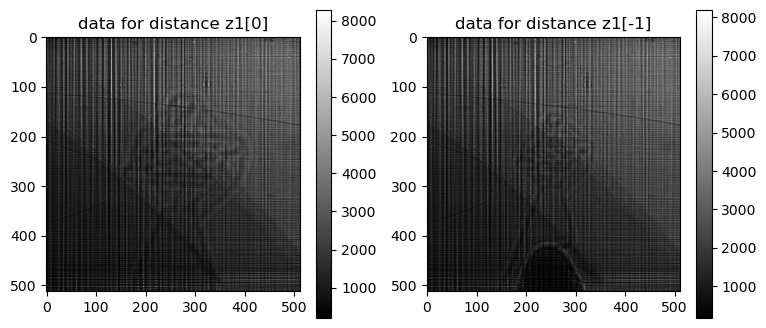

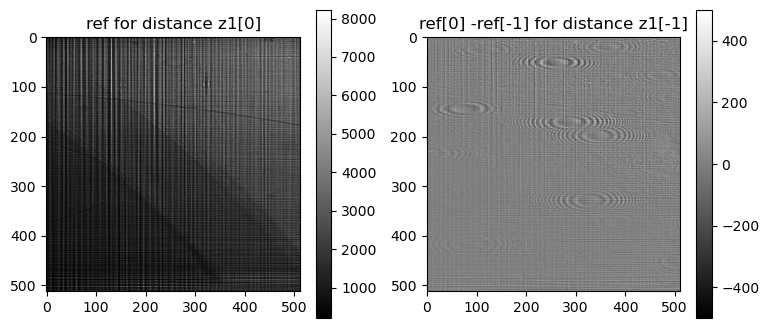

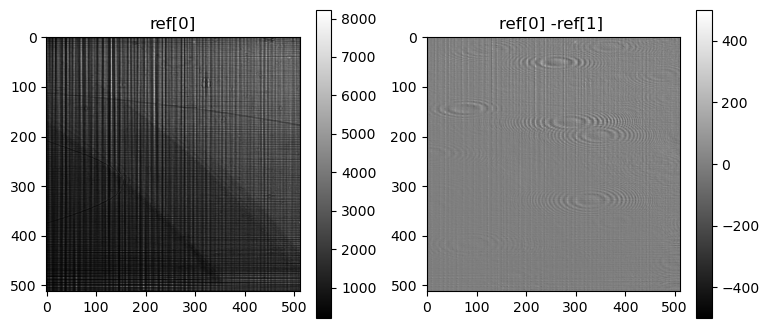

In [5]:
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(data0[0,0],cmap='gray')
    axs[0].set_title('data for distance z1[0]')
    fig.colorbar(im)
    im=axs[1].imshow(data0[-1,0],cmap='gray')
    axs[1].set_title('data for distance z1[-1]')
    fig.colorbar(im)

    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(ref0[0],cmap='gray')
    axs[0].set_title('ref for distance z1[0]')
    fig.colorbar(im)
    im=axs[1].imshow(ref0[0]-ref0[-1],cmap='gray',vmin=-500,vmax=500)
    axs[1].set_title('ref[0] -ref[-1] for distance z1[-1]')
    fig.colorbar(im)
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(ref0[0],cmap='gray')
    axs[0].set_title('ref[0]')
    fig.colorbar(im)
    im=axs[1].imshow(ref0[0]-ref0[1],cmap='gray',vmin=-500,vmax=500)
    axs[1].set_title('ref[0] -ref[1] ')
    fig.colorbar(im)

# use second ref
# ref0 = np.mean(ref0,axis=0)[np.newaxis]

# find shifts between flat fields

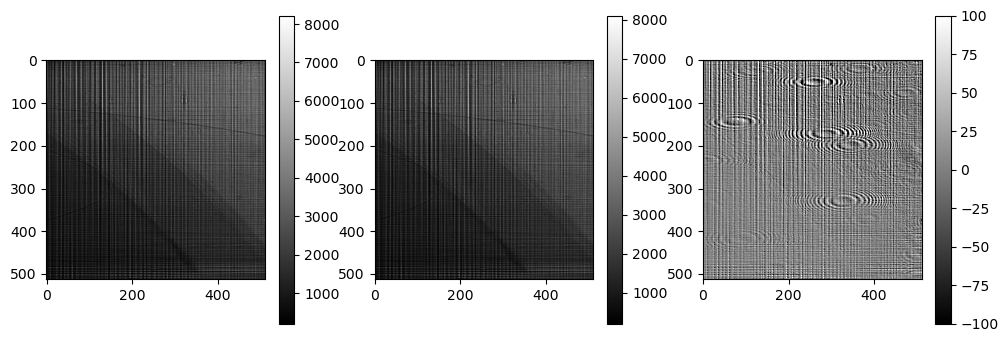

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im=axs[0].imshow(ref0[0],cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(ref0[1],cmap='gray')
fig.colorbar(im)
im=axs[2].imshow(ref0[2]-ref0[0],cmap='gray',vmin=-100,vmax=100)
fig.colorbar(im)

In [7]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    print(shift.shape,tmp.shape)
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

print(ref0.shape,ref0.dtype)
shifts_ref = np.zeros([ndist,2],dtype='float32')
for k in range(ndist):
    shifts_ref[k] = registration_shift(ref0[k:k+1,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],ref0[0:1,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],upsample_factor=1000)
print(shifts_ref)
ref0_copy = ref0.copy()
dxchange.write_tiff_stack(ref0,f'/data/viktor/tmp/ref.tiff',overwrite=True)
for k in range(ndist):
    ref0_copy[k:k+1] = apply_shift(ref0[k:k+1],-shifts_ref[k:k+1])
dxchange.write_tiff_stack(ref0_copy,f'/data/viktor/tmp/ref_aligned.tiff',overwrite=True)
# print(f'{k} {j}: {shifts_random[k,j:j+1]/2**binning} {shifts_dist[k,j]}')


(4, 512, 512) float32
[[ 0.     0.   ]
 [ 0.016 -0.035]
 [ 0.038 -0.071]
 [ 0.064 -0.046]]
(1, 1024, 513) (1, 1024, 1024)
(1, 1024, 513) (1, 1024, 1024)
(1, 1024, 513) (1, 1024, 1024)
(1, 1024, 513) (1, 1024, 1024)


NameError: name 'kk' is not defined